In [1]:
from analysis import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from scipy.interpolate import make_interp_spline
import seaborn as sns
from matplotlib import rc

In [2]:
rc('text', usetex=True)
rc('font', family='sans-serif')

In [3]:
eps_set = [[0.05, 241], [0.1143, 199], [0.1786, 159], [0.2429, 123], 
           [0.3071, 89], [0.3714, 66], [0.4357, 58], [0.5, 58]]# np.array([[0.05, 80], [0.1143, 56], [0.1786, 41], 
                   # [0.2429, 32], [0.3071, 29], [0.3714, 25], [0.4357, 24], [0.5, 24]])
eps_thresh = [j for (i,j) in eps_set]
data_path = "arm3_eps_v2/data"
files = get_files_in_directory(data_path)
N = len(files)

In [4]:
pop_acc = []; ids = []
for f in files:
    pid, df, acc = load(f, eps_thresh, True)
    ids.append(pid); pop_acc.append(acc)
pop_mean_acc = np.mean(pop_acc)
print(pop_mean_acc)

60ffd7de4dc3ea2bfd477a22,1.4
5cd1bdedf2156c00013b0152,1.37
61648e4f0d2212047ab36b27,1.64
0.6532


In [5]:
print(ids, '\n', pop_acc)

['615d50afaa1ddf26457e079c', '60ffd7de4dc3ea2bfd477a22', '5cd1bdedf2156c00013b0152', '61648e4f0d2212047ab36b27', '5bf890e426e31d0001040667'] 
 [0.642, 0.672, 0.688, 0.677, 0.587]


# theoretical predictions

In [6]:
path = '../model/sims/'
df_eps = pd.read_csv(path+'eps_simulate_1000_q0.75_2023-07-28.csv')

Text(0.5, 1.0, 'Model predictions for mean commitment time as a function of $\\epsilon$')

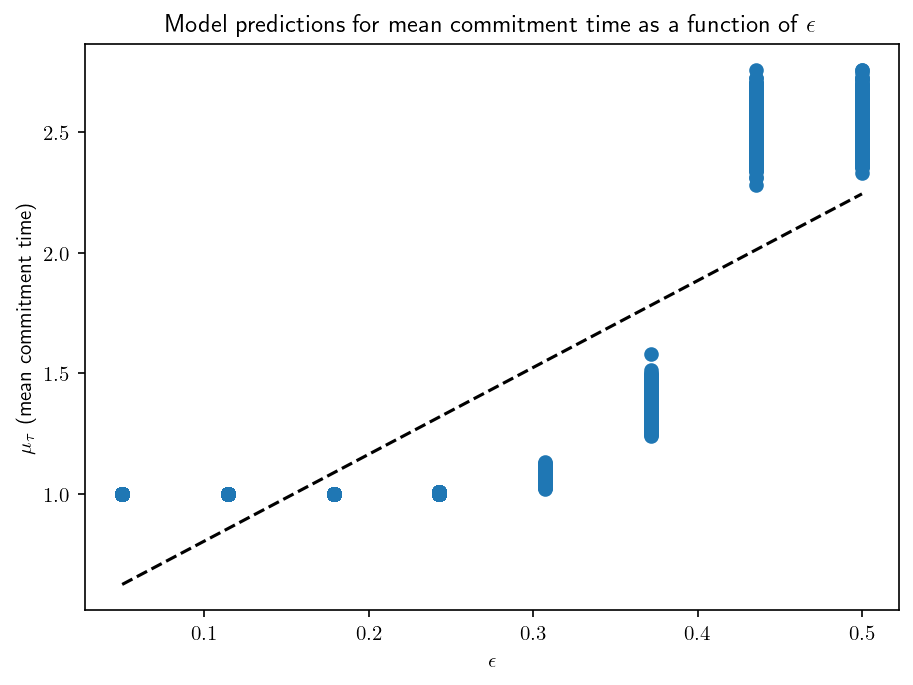

In [7]:
fig, ax = plt.subplots(figsize=(7,5),dpi=150)
plt.subplots_adjust(wspace=0.2)
x,y = np.array(df_eps['eps']).reshape(-1,1), np.array(df_eps['mu_i']).reshape(-1,1)
plt.scatter(x,y)
fit_eps, fit_mu, __, __ = get_linear_fit(x,y)
plt.plot(fit_eps, fit_mu, 'k--')
plt.xlabel('$\epsilon$')
plt.ylabel('$\mu_\\tau$ (mean commitment time)')
plt.title('Model predictions for mean commitment time as a function of $\epsilon$')

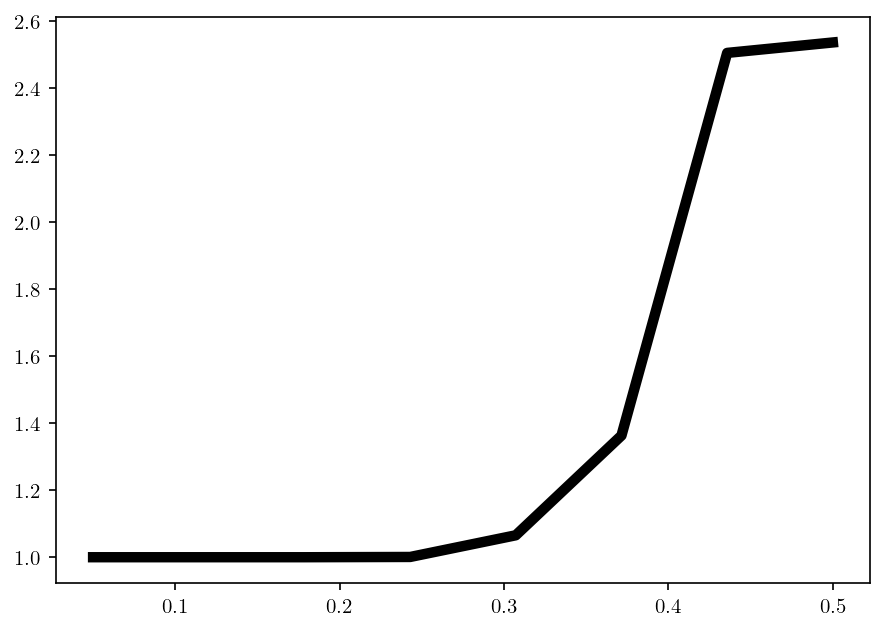

In [8]:
mdl_avg_eps = []
for e in df_eps['eps'].unique():
    eps_level = df_eps[df_eps['eps'] == e]['mu_i']
    mdl_avg_eps.append(np.mean(eps_level))
fig, ax = plt.subplots(figsize=(7,5),dpi=150)
plt.subplots_adjust(wspace=0.2)
plt.plot(df_eps['eps'].unique(), mdl_avg_eps, c='black', linewidth=5)

# comparison before and after discarding first 70 trials

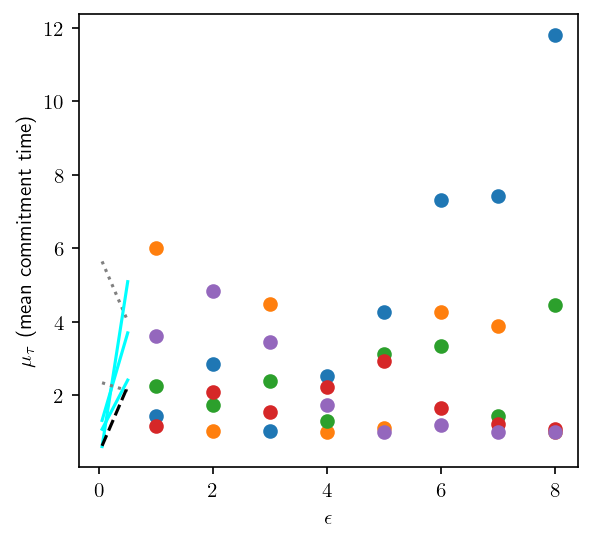

In [9]:
fig, ax = plt.subplots(figsize=(9,4),dpi=150)
plt.subplots_adjust(wspace=0.1)
plt.subplot(121)
pop_acc = []
for f in files:
    pid, df, acc = load(f, eps_thresh)
    pop_acc.append(acc)
pop_mean_acc = np.mean(pop_acc)
for f in files:
    pid, df, acc = load(f, eps_thresh)
    if np.abs(acc - pop_mean_acc) < 2*np.std(pop_acc):
        __, eps, mu_i, __ = get_mean_iai(df)
        x,y,l,c = get_linear_fit(eps,mu_i)
        plt.scatter(np.linspace(1,8,8),mu_i)
        plt.plot(x,y, linestyle = l, c=c)
plt.xlabel('$\epsilon$')
plt.ylabel('$\mu_\\tau$ (mean commitment time)')
plt.plot(fit_eps, fit_mu, 'k--')

In [10]:
eps

array([[0.4357],
       [0.3071],
       [0.05  ],
       [0.1143],
       [0.1786],
       [0.5   ],
       [0.3714],
       [0.2429]])

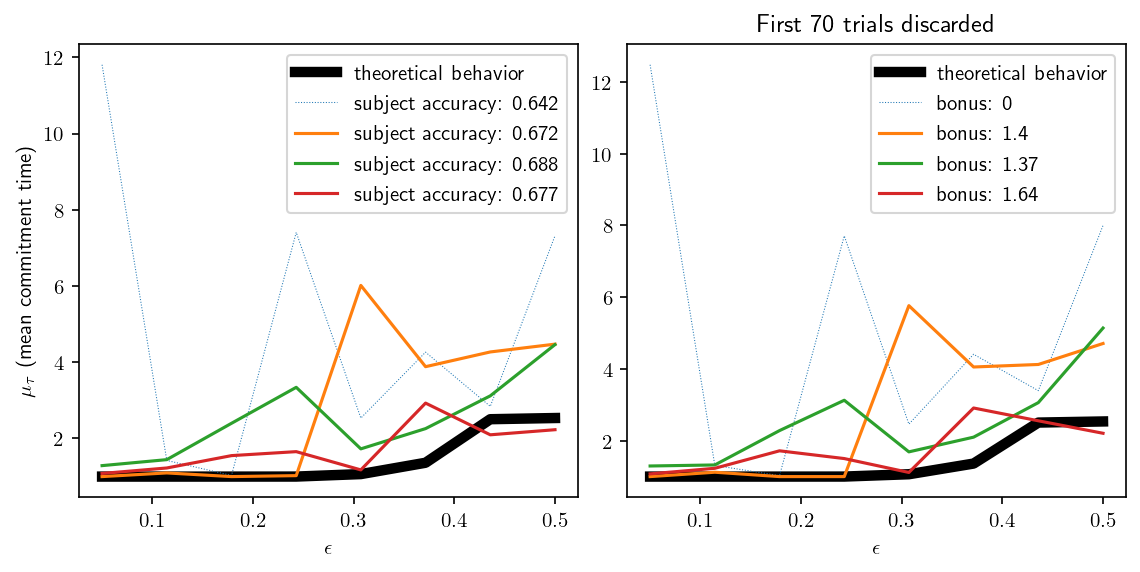

In [11]:
fig, ax = plt.subplots(figsize=(9,4),dpi=150)
plt.subplots_adjust(wspace=0.1)
plt.subplot(121)
plt.plot(df_eps['eps'].unique(), mdl_avg_eps, c='black', linewidth=5, label = 'theoretical behavior')
pop_acc = []
for f in files:
    pid, df, acc = load(f, eps_thresh)
    pop_acc.append(acc)
pop_mean_acc = np.mean(pop_acc)
for f in files:
    pid, df, acc = load(f, eps_thresh)
    if np.abs(acc - pop_mean_acc) < 1.25*np.std(pop_acc):
        __, eps, mu_i, __ = get_mean_iai(df)
        xy = np.concatenate((eps[:,0].reshape(-1,1), mu_i[:,0].reshape(-1,1)), axis=1)
        xy = pd.DataFrame(xy, columns = ["x", "y"])
        xy = xy.sort_values('x')
        if compute_bonus(df, eps_thresh) == 0:
            plt.plot(np.array(xy["x"]), np.array(xy["y"]), linestyle = 'dotted', linewidth=0.5, label = 'subject accuracy: ' + str(acc))
        else:
            plt.plot(np.array(xy["x"]), np.array(xy["y"]), label = 'subject accuracy: ' + str(acc))
        x,y,l,c = get_linear_fit(eps,mu_i)
plt.xlabel('$\epsilon$')
plt.ylabel('$\mu_\\tau$ (mean commitment time)')
plt.legend()


plt.subplot(122)
discard = 70
pop_acc = []
plt.plot(df_eps['eps'].unique(), mdl_avg_eps, c='black', linewidth=5, label = 'theoretical behavior')
for f in files:
    pid, df, acc = load(f, eps_thresh)
    pop_acc.append(acc)
pop_mean_acc = np.mean(pop_acc)
for f in files:
    pid, df, acc = load(f, eps_thresh)
    if np.abs(acc - pop_mean_acc) < np.std(pop_acc):
        __, eps, mu_i, __ = get_mean_iai(df, discard)
        xy = np.concatenate((eps[:,0].reshape(-1,1), mu_i[:,0].reshape(-1,1)), axis=1)
        xy = pd.DataFrame(xy, columns = ["x", "y"])
        xy = xy.sort_values('x')
        if compute_bonus(df, eps_thresh) == 0:
            plt.plot(np.array(xy["x"]), np.array(xy["y"]), linestyle = 'dotted', linewidth=0.5, label = 'bonus: ' + str(compute_bonus(df,eps_thresh)))
        else:
            plt.plot(np.array(xy["x"]), np.array(xy["y"]), label = 'bonus: ' + str(compute_bonus(df,eps_thresh)))
        x,y,l,c = get_linear_fit(eps,mu_i)
plt.xlabel('$\epsilon$')
plt.title("First 70 trials discarded")
plt.legend()

Text(0.5, 1.0, 'Accuracy across blocks for arm3\\_eps')

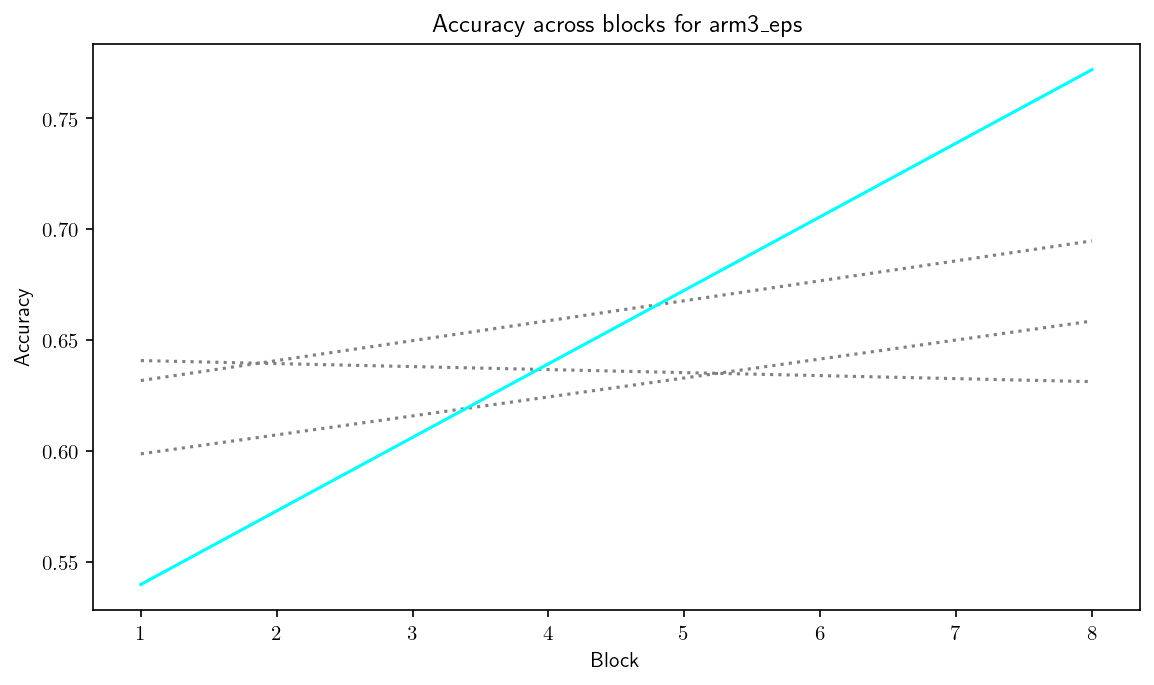

In [12]:
fig, ax = plt.subplots(figsize=(9,5),dpi=150)
plt.subplots_adjust(wspace=0.2)
for f in files:
    pid, df, acc = load(f, eps_thresh)
    if np.abs(acc - pop_mean_acc) < 1.25*np.std(pop_acc):
        __, eps, acc_i = get_accuracy(df)
        rounds = np.linspace(1,8,8).reshape(-1,1)
        x,y,l,c = get_linear_fit(rounds,acc_i)
        plt.plot(x,y, linestyle = l, c=c)
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy across blocks for arm3\_eps')
# plt.plot(fit_q, fit_mu, 'k--')

Text(0.5, 1.0, 'Accuracy across blocks for arm3\\_q')

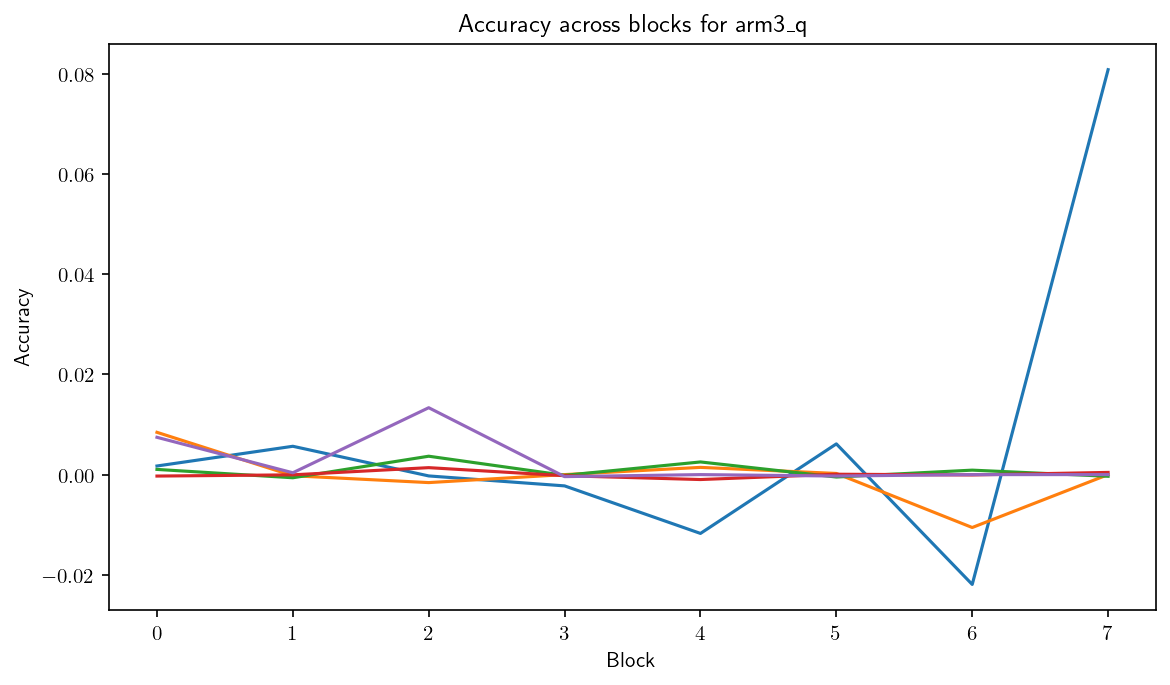

In [14]:
fig, ax = plt.subplots(figsize=(9,5),dpi=150)
plt.subplots_adjust(wspace=0.2)
belief = []
for f in files:
    pid, df, acc = load(f, eps_thresh)
    q, eps, thr = get_abs_threshold(df)
    belief.append(thr)
    plt.plot(thr)
#     plt.plot(down_price)
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy across blocks for arm3\_q')
# plt.plot(fit_q, fit_mu, 'k--')

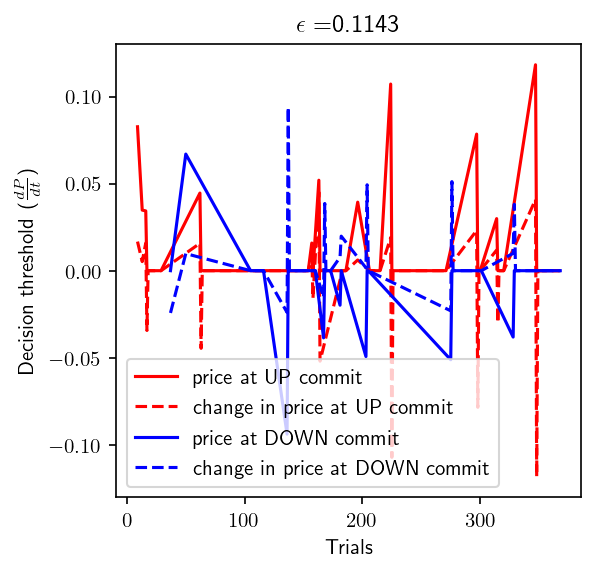

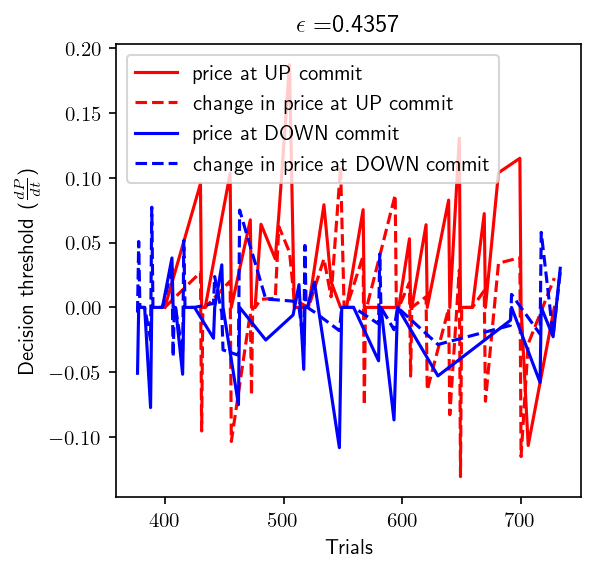

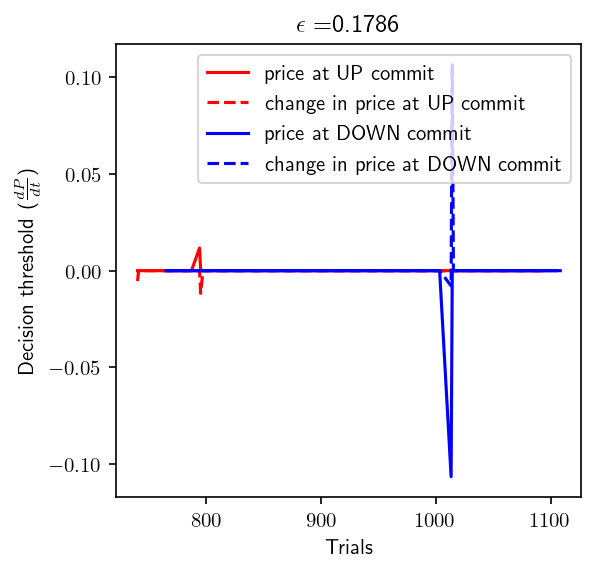

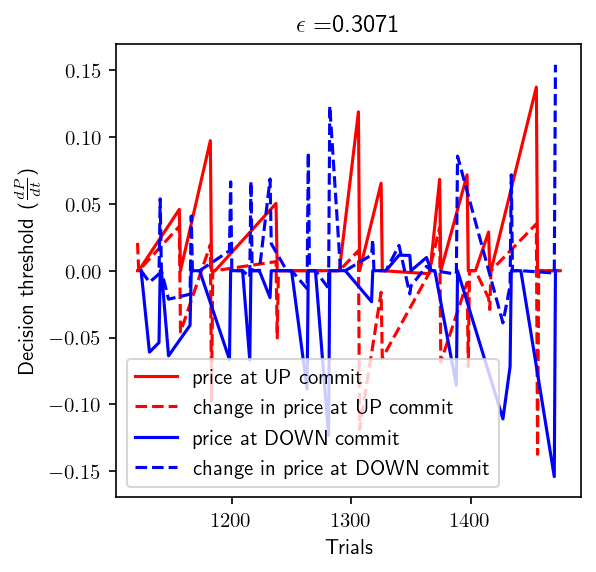

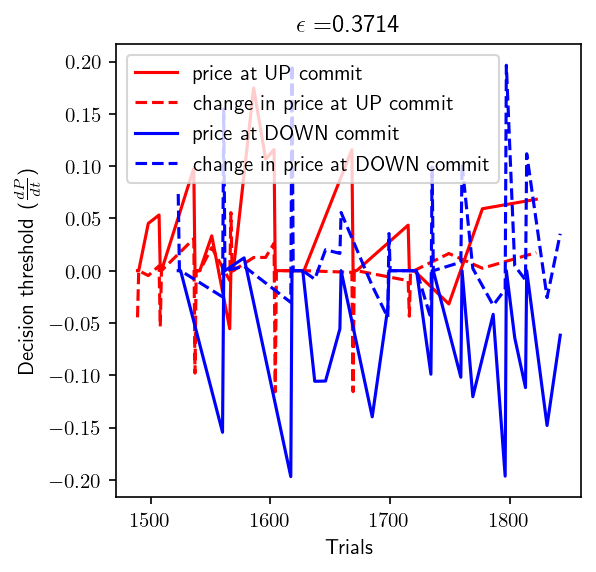

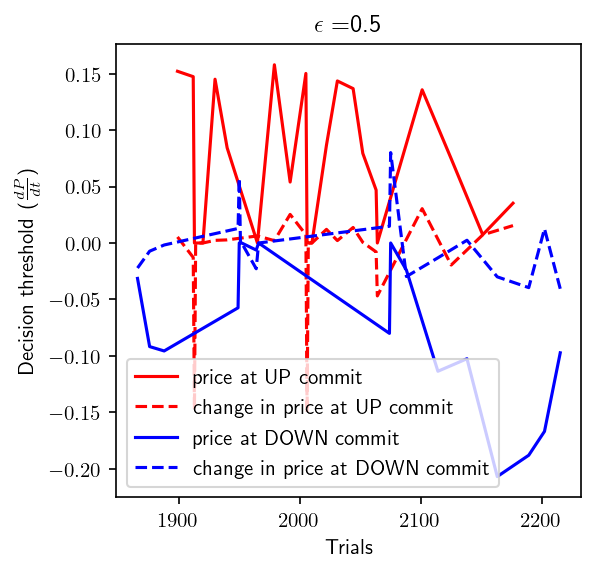

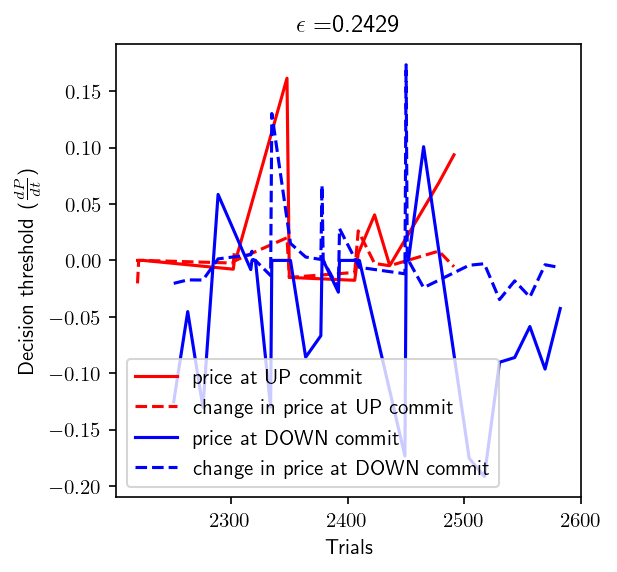

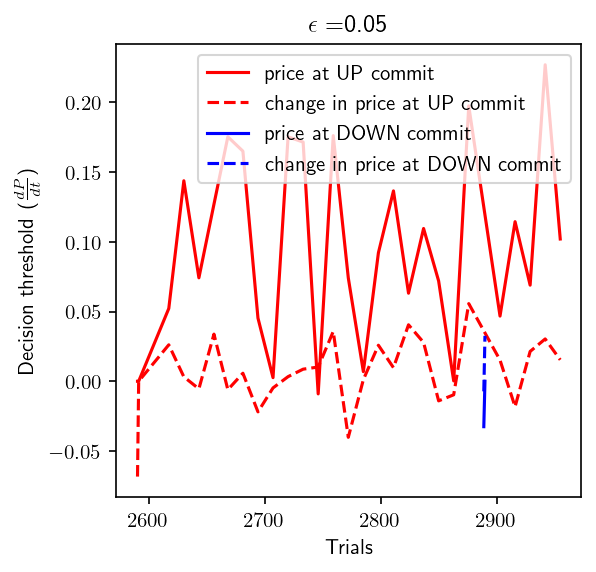

In [14]:
for i in range(1,numBlocks+1):
    fig, ax = plt.subplots(figsize=(4,4),dpi=150)
    curBlock = block(i,df, 0)
    ups = curBlock.index[curBlock['resp.keys'] == 1]
    ups = ups - 1
    ups = ups[1:]
    downs = curBlock.index[curBlock['resp.keys'] == -1]
    downs = downs - 1
    downs = downs[1:]
    both = curBlock.index[np.abs(curBlock['resp.keys']) == 1]
    both = both - 1
    both = both[1:]
    plt.plot(df.iloc[ups]['price'], 'r', label = 'price at UP commit')
    plt.plot(df.iloc[ups]['dPrice_dt'], 'r--', label = 'change in price at UP commit')
    plt.plot(df.iloc[downs]['price'], 'b', label = 'price at DOWN commit')
    plt.plot(df.iloc[downs]['dPrice_dt'], 'b--', label = 'change in price at DOWN commit')
    plt.xlabel('Trials')
    plt.ylabel('Decision threshold ($\\frac{dP}{dt}$)')
    plt.title('$\epsilon = $' + str(curBlock['eps_prob'].iloc[0]))
    plt.legend()
    plt.show()

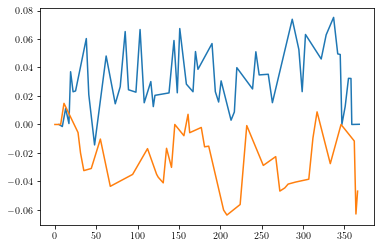

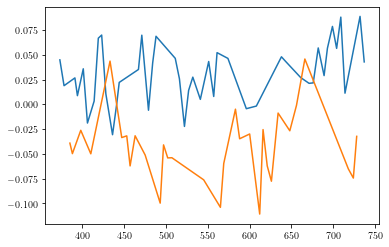

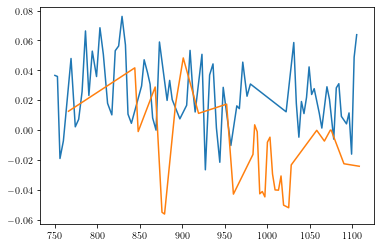

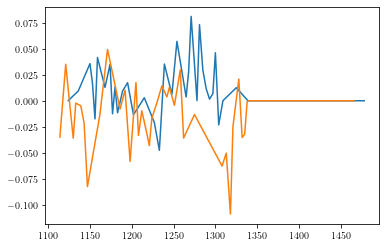

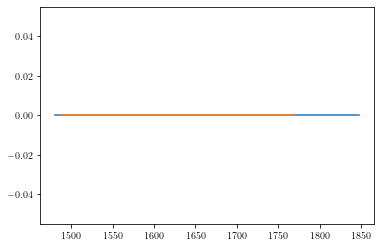

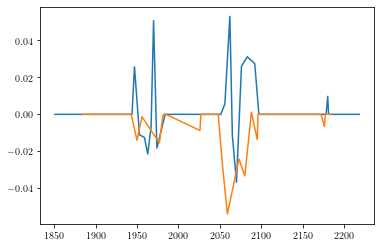

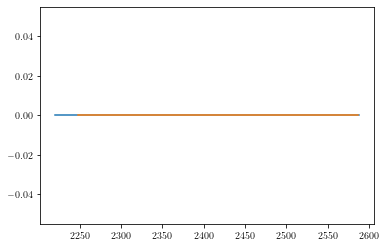

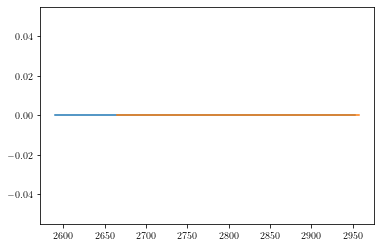

In [38]:
for i in range(1,numBlocks+1):
    curBlock = block(i,df, 0)
    ups = curBlock.index[curBlock['resp.keys'] == 1]
    ups = ups - 1
    ups = ups[1:]
    downs = curBlock.index[curBlock['resp.keys'] == -1]
    downs = downs - 1
    downs = downs[1:]
    plt.plot(df.iloc[ups]['price'])
    plt.plot(df.iloc[downs]['price'])
    plt.show()